<a href="https://colab.research.google.com/github/Snika987/AAI-Projecy/blob/main/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XGBoost for credit risk calculation









## 1: Imports and Setup

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
import shap
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('credit_risk_dataset.csv')

# 2: Exploratory Data Analysis (EDA)

In [4]:
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [5]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64


In [6]:
print("\nTarget Variable Distribution:")
print(df['loan_status'].value_counts(normalize=True) * 100)


Target Variable Distribution:
loan_status
0    78.183604
1    21.816396
Name: proportion, dtype: float64


In [7]:
# Summary statistics
print("\nSummary Statistics for Numerical Features:")
print(df.describe())


Summary Statistics for Numerical Features:
         person_age  person_income  person_emp_length     loan_amnt  \
count  32581.000000   3.258100e+04       31686.000000  32581.000000   
mean      27.734600   6.607485e+04           4.789686   9589.371106   
std        6.348078   6.198312e+04           4.142630   6322.086646   
min       20.000000   4.000000e+03           0.000000    500.000000   
25%       23.000000   3.850000e+04           2.000000   5000.000000   
50%       26.000000   5.500000e+04           4.000000   8000.000000   
75%       30.000000   7.920000e+04           7.000000  12200.000000   
max      144.000000   6.000000e+06         123.000000  35000.000000   

       loan_int_rate   loan_status  loan_percent_income  \
count   29465.000000  32581.000000         32581.000000   
mean       11.011695      0.218164             0.170203   
std         3.240459      0.413006             0.106782   
min         5.420000      0.000000             0.000000   
25%         7.900000 

In [8]:
# Categorical feature distributions
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
for col in categorical_cols:
    print(f"\n{col} Distribution:")
    print(df[col].value_counts())


person_home_ownership Distribution:
person_home_ownership
RENT        16446
MORTGAGE    13444
OWN          2584
OTHER         107
Name: count, dtype: int64

loan_intent Distribution:
loan_intent
EDUCATION            6453
MEDICAL              6071
VENTURE              5719
PERSONAL             5521
DEBTCONSOLIDATION    5212
HOMEIMPROVEMENT      3605
Name: count, dtype: int64

loan_grade Distribution:
loan_grade
A    10777
B    10451
C     6458
D     3626
E      964
F      241
G       64
Name: count, dtype: int64

cb_person_default_on_file Distribution:
cb_person_default_on_file
N    26836
Y     5745
Name: count, dtype: int64


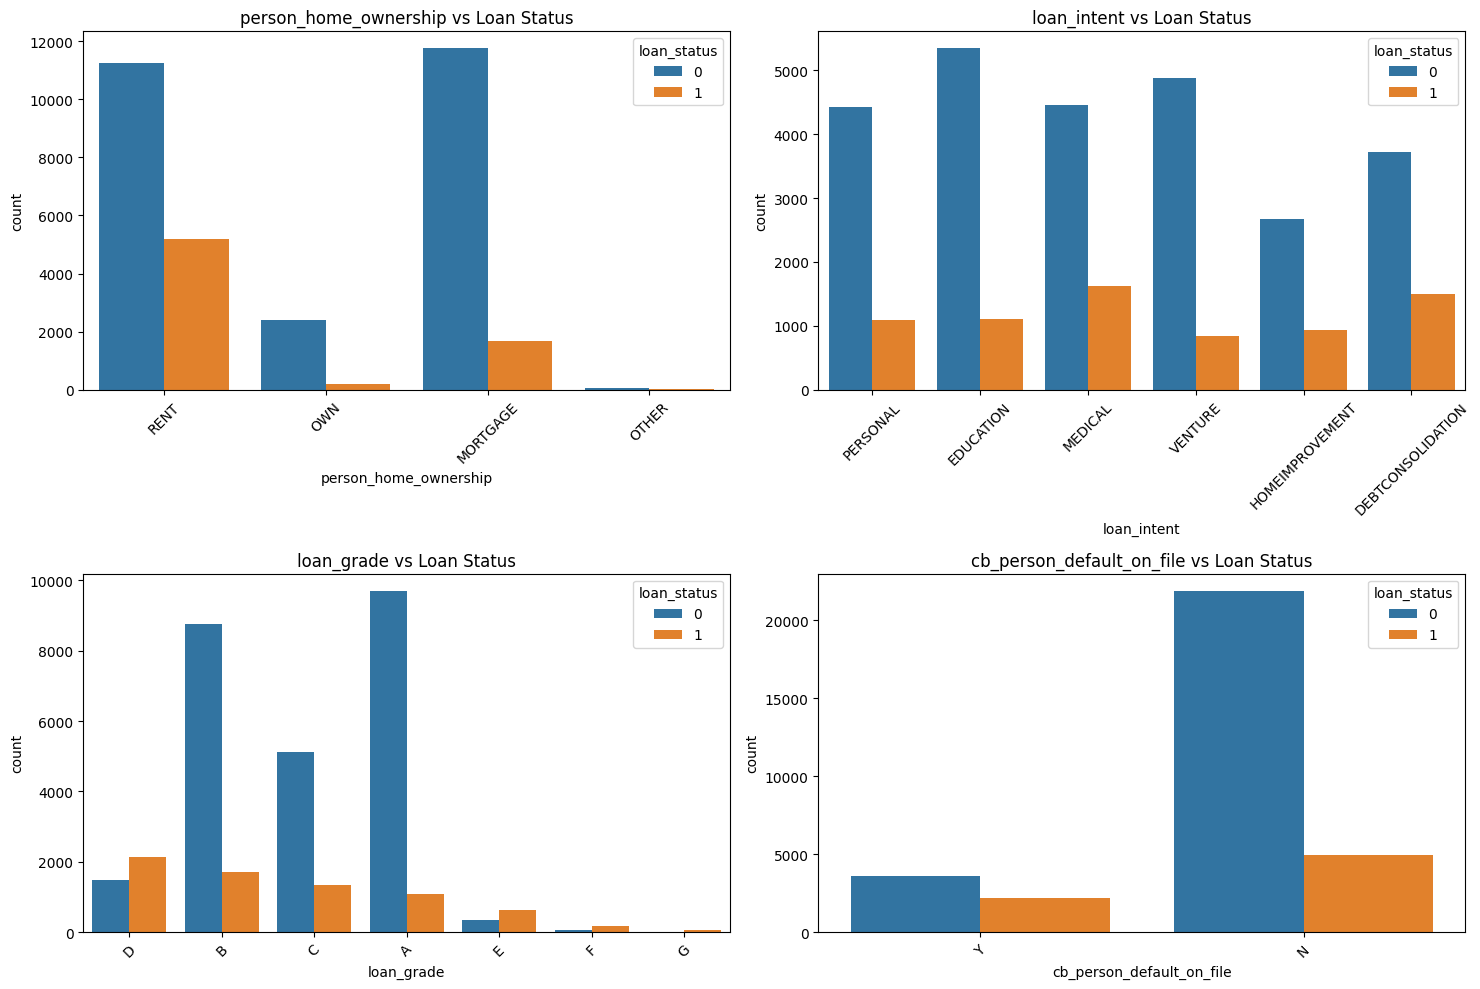

In [9]:
# Visualizations: Categorical Features
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=col, hue='loan_status', data=df)
    plt.title(f'{col} vs Loan Status')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

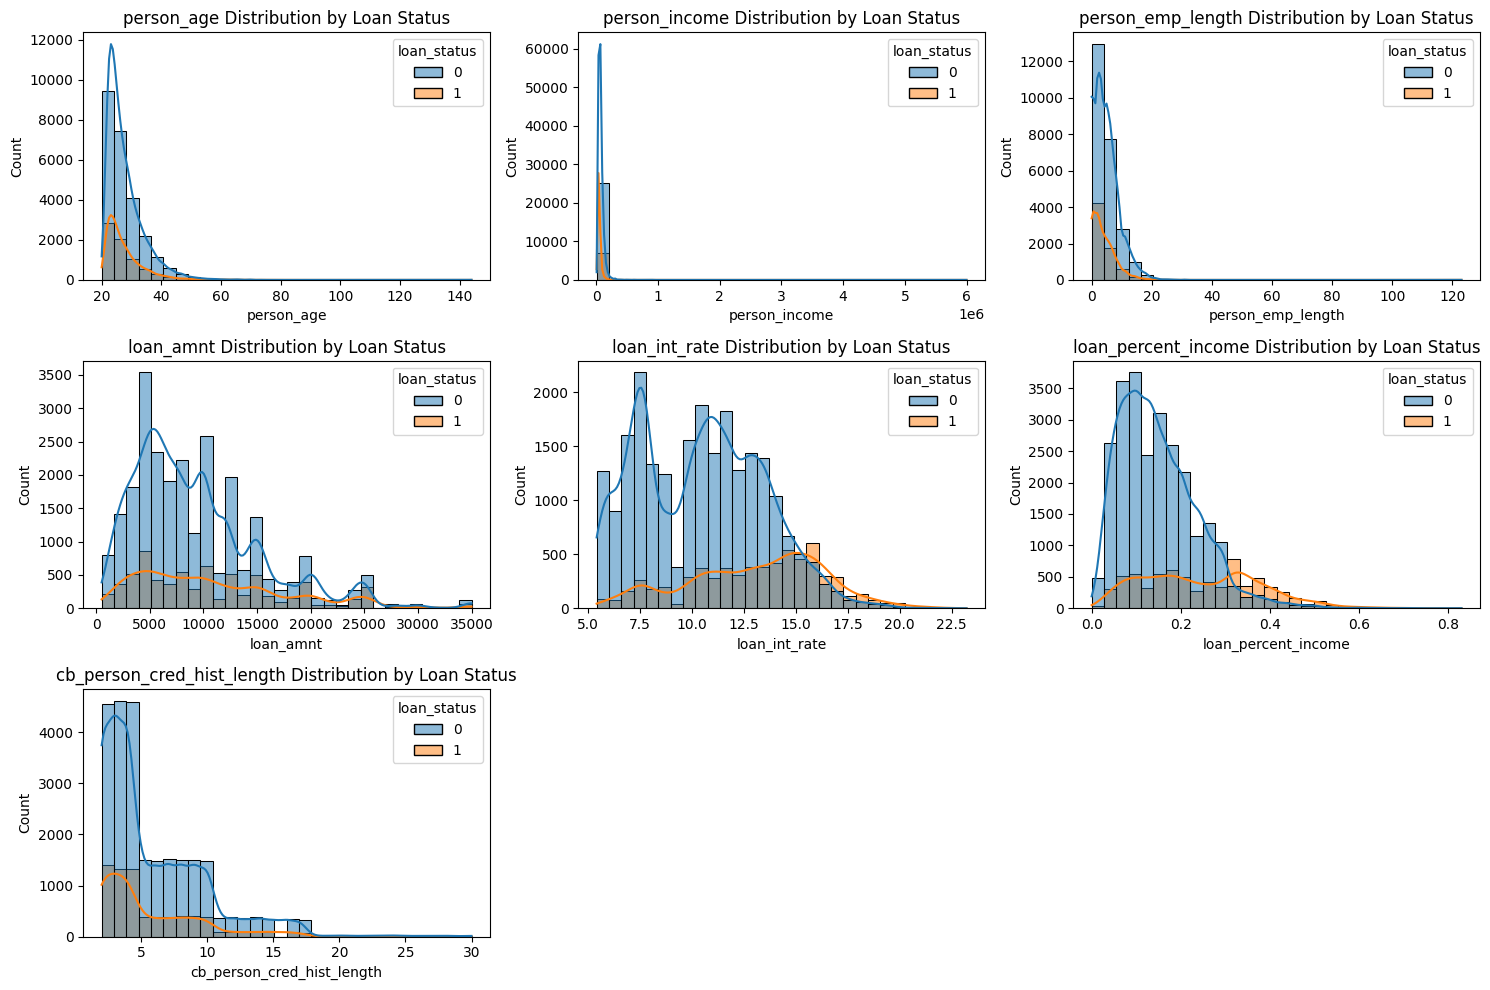

In [10]:
# Visualizations: Numerical Features
numerical_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
                  'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=df, x=col, hue='loan_status', kde=True, bins=30)
    plt.title(f'{col} Distribution by Loan Status')
plt.tight_layout()
plt.show()

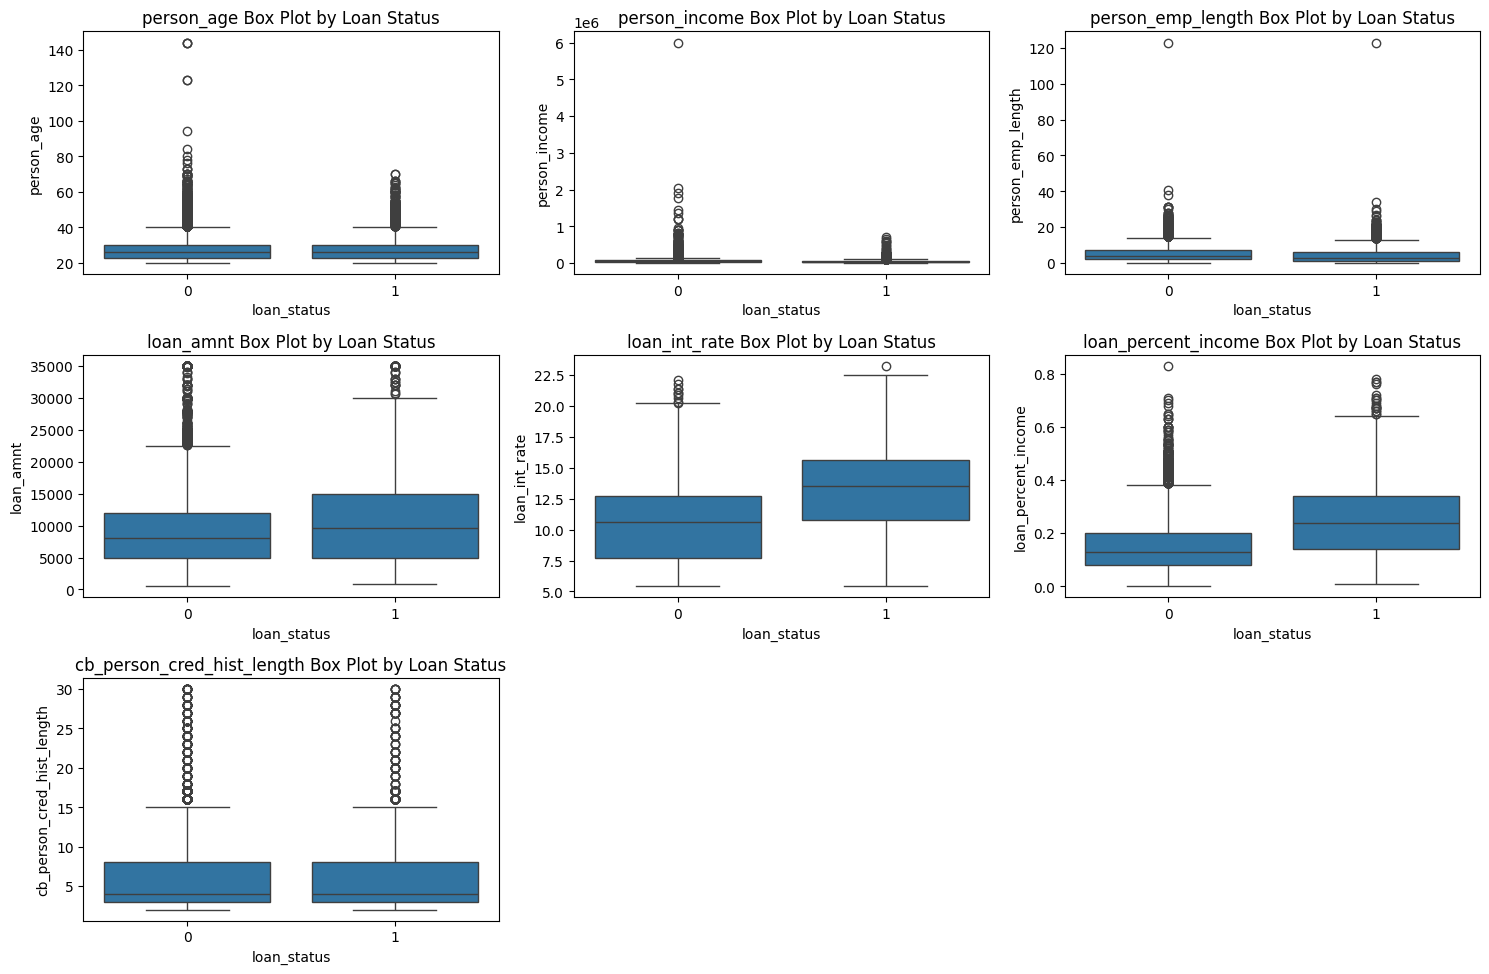

In [11]:
# Box plots for numerical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='loan_status', y=col, data=df)
    plt.title(f'{col} Box Plot by Loan Status')
plt.tight_layout()
plt.show()

3: Data Preprocessing and One-Hot Encoding

In [12]:
# --- Data Preprocessing ---
# Handle missing values
df['person_emp_length'].fillna(df['person_emp_length'].median(), inplace=True)
df['loan_int_rate'].fillna(df['loan_int_rate'].median(), inplace=True)

# Remove outliers
df = df[df['person_emp_length'] <= 50]

# --- One-Hot Encoding ---
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
numerical_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
                  'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_cols = pd.DataFrame(encoder.fit_transform(df[categorical_cols]),
                           columns=encoder.get_feature_names_out(categorical_cols),
                           index=df.index)  # Ensure index alignment

# Combine encoded columns with numerical features
X = pd.concat([df[numerical_cols], encoded_cols], axis=1)
y = df['loan_status']

# Verify shapes
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (32579, 22)
y shape: (32579,)


4: Feature Engineering and Train-Test Split

In [13]:
# --- Feature Engineering ---
X['income_loan_ratio'] = X['person_income'] / X['loan_amnt']
X['debt_to_income'] = X['loan_amnt'] / X['person_income']

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Verify shapes after feature engineering
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (26063, 24)
X_test shape: (6516, 24)


5: Evaluation Function

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'F1 Macro': f1_score(y_test, y_pred, average='macro')
    }
    cv_scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=5)
    metrics['CV F1 Macro'] = cv_scores.mean()

    print(f"\n{model_name} Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()
    return metrics

6: Vanilla XGBoost


Vanilla XGBoost Performance:
Accuracy: 0.9282
Precision: 0.9466
Recall: 0.7108
F1: 0.8119
F1 Macro: 0.8838
CV F1 Macro: 0.8894

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      5095
           1       0.95      0.71      0.81      1421

    accuracy                           0.93      6516
   macro avg       0.94      0.85      0.88      6516
weighted avg       0.93      0.93      0.92      6516



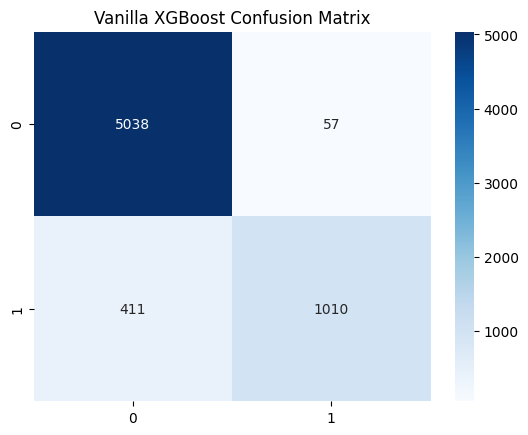

In [15]:
import xgboost as xgb

# Assuming X_train, X_test, y_train, y_test, evaluate_model from previous chunks
# --- Vanilla XGBoost ---
original_cols = [col for col in X_train.columns if col not in ['income_loan_ratio', 'debt_to_income']]
X_train_vanilla = X_train[original_cols]
X_test_vanilla = X_test[original_cols]

xgb_vanilla = xgb.XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    learning_rate=0.1,
    n_estimators=100,
    max_depth=5,
    reg_alpha=0.1,
    reg_lambda=1.0
)
vanilla_metrics = evaluate_model(xgb_vanilla, X_train_vanilla, X_test_vanilla, y_train, y_test, "Vanilla XGBoost")

<Figure size 640x480 with 0 Axes>

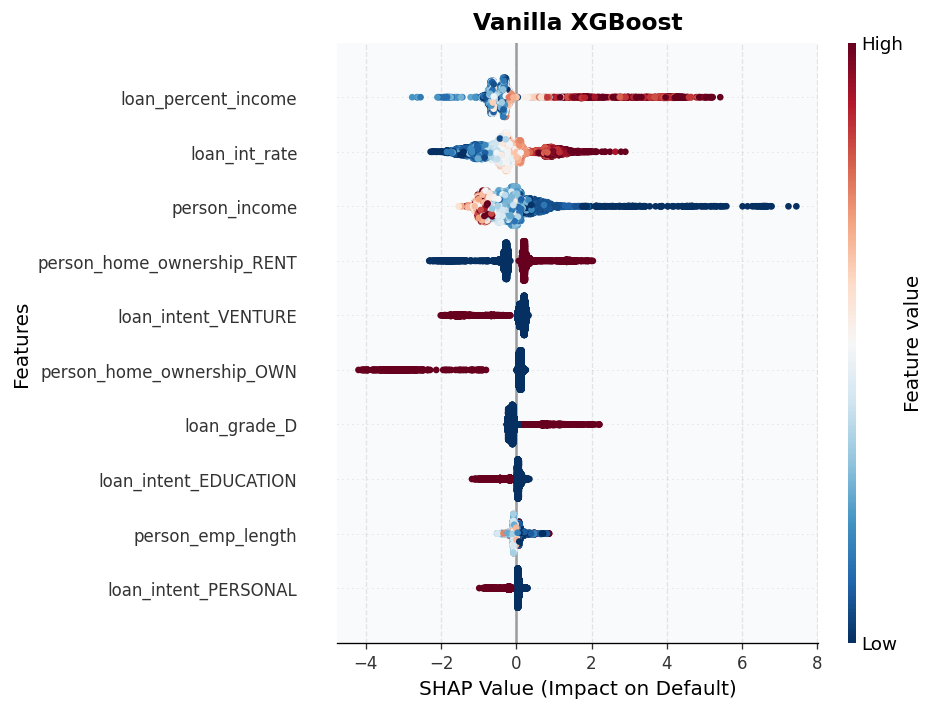

In [16]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming xgb_vanilla, X_test_vanilla from previous chunks
# --- SHAP Analysis for Vanilla XGBoost ---
plt.clf()
plt.rcParams['axes.facecolor'] = '#F9FAFB'
plt.rcParams['figure.dpi'] = 120

try:
    explainer = shap.TreeExplainer(xgb_vanilla)
    shap_values = explainer.shap_values(X_test_vanilla)
    plt.figure(figsize=(8, 6))
    shap.summary_plot(
        shap_values,
        X_test_vanilla,
        plot_type='dot',  # Beeswarm plot
        max_display=10,  # Top 10 features
        show=False,
        cmap=plt.cm.get_cmap('RdBu_r'),  # Red: positive, Blue: negative
        plot_size=None
    )
    plt.title('Vanilla XGBoost', fontsize=14, pad=8, weight='bold')
    plt.xlabel('SHAP Value (Impact on Default)', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.gca().tick_params(axis='both', which='major', labelsize=10)
    plt.gca().set_facecolor('#F9FAFB')
    plt.grid(True, axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout(pad=1.0)
    plt.show()
except Exception as e:
    print(f"Error in SHAP for Vanilla XGBoost: {e}")

7: XGB with weighted class


XGBoost with Weighted Classes Performance:
Accuracy: 0.8938
Precision: 0.7468
Recall: 0.7762
F1: 0.7612
F1 Macro: 0.8465
CV F1 Macro: 0.8595

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      5095
           1       0.75      0.78      0.76      1421

    accuracy                           0.89      6516
   macro avg       0.84      0.85      0.85      6516
weighted avg       0.90      0.89      0.89      6516



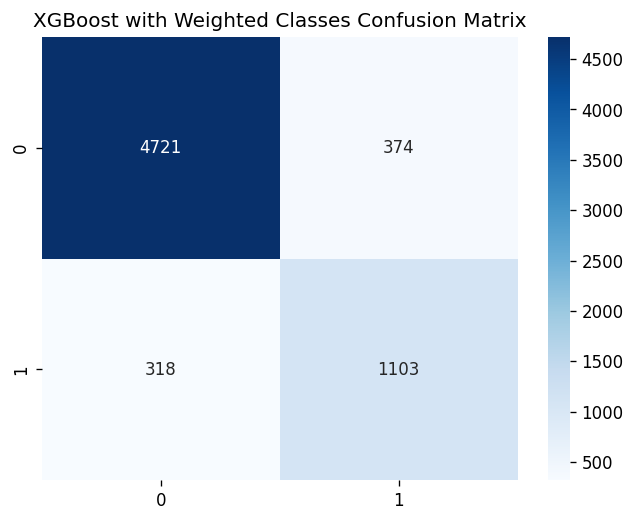

In [17]:
import xgboost as xgb

# Assuming X_train, X_test, y_train, y_test, evaluate_model from previous chunks
# --- XGBoost with Weighted Classes ---
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()  # Ratio of negative to positive class

xgb_weighted = xgb.XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    learning_rate=0.1,
    n_estimators=100,
    max_depth=5,
    reg_alpha=0.1,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight
)
weighted_metrics = evaluate_model(xgb_weighted, X_train, X_test, y_train, y_test, "XGBoost with Weighted Classes")

<Figure size 768x576 with 0 Axes>

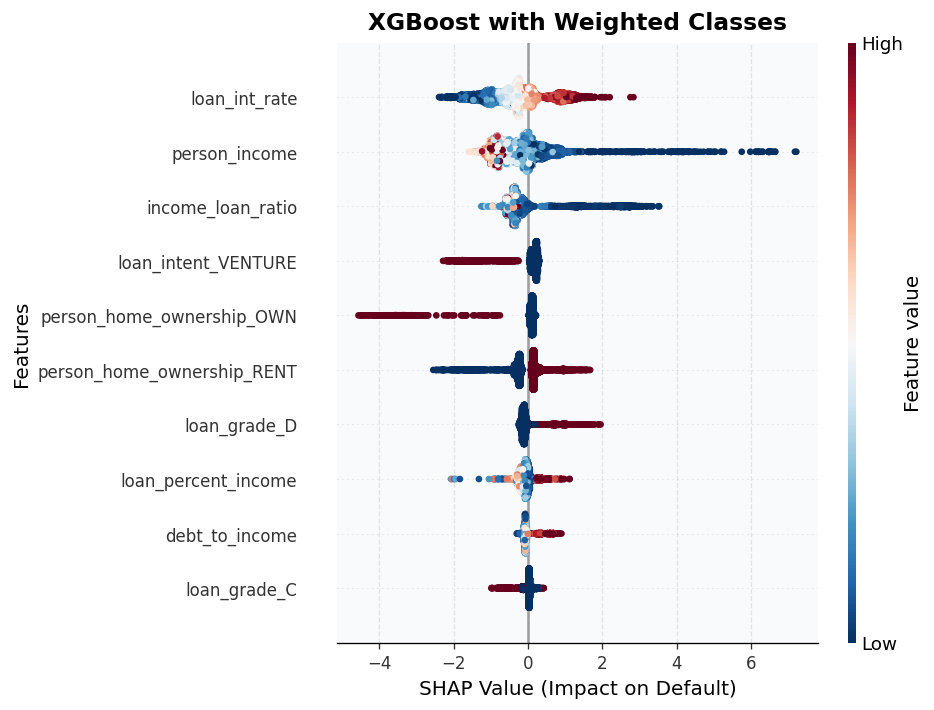

In [18]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming xgb_weighted, X_test from previous chunks
# --- SHAP Analysis for XGBoost with Weighted Classes ---
plt.clf()
plt.rcParams['axes.facecolor'] = '#F9FAFB'
plt.rcParams['figure.dpi'] = 120

try:
    explainer = shap.TreeExplainer(xgb_weighted)
    shap_values = explainer.shap_values(X_test)
    plt.figure(figsize=(8, 6))
    shap.summary_plot(
        shap_values,
        X_test,
        plot_type='dot',  # Beeswarm plot
        max_display=10,  # Top 10 features
        show=False,
        cmap=plt.cm.get_cmap('RdBu_r'),  # Red: positive, Blue: negative
        plot_size=None
    )
    plt.title('XGBoost with Weighted Classes', fontsize=14, pad=8, weight='bold')
    plt.xlabel('SHAP Value (Impact on Default)', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.gca().tick_params(axis='both', which='major', labelsize=10)
    plt.gca().set_facecolor('#F9FAFB')
    plt.grid(True, axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout(pad=1.0)
    plt.show()
except Exception as e:
    print(f"Error in SHAP for XGBoost with Weighted Classes: {e}")

8: XGBoost with Feature Engineering


XGBoost with Feature Engineering Performance:
Accuracy: 0.9288
Precision: 0.9536
Recall: 0.7080
F1: 0.8126
F1 Macro: 0.8843
CV F1 Macro: 0.8898

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      5095
           1       0.95      0.71      0.81      1421

    accuracy                           0.93      6516
   macro avg       0.94      0.85      0.88      6516
weighted avg       0.93      0.93      0.92      6516



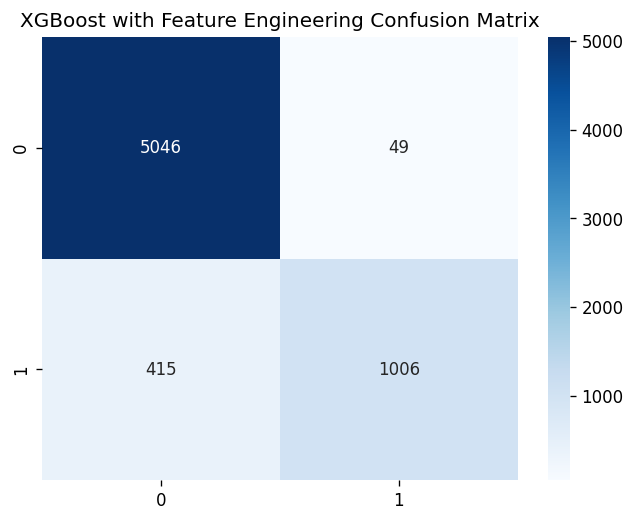

In [19]:
# --- XGBoost with Feature Engineering ---
xgb_fe = xgb.XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    learning_rate=0.1,
    n_estimators=100,
    max_depth=5,
    reg_alpha=0.1,
    reg_lambda=1.0
)
fe_metrics = evaluate_model(xgb_fe, X_train, X_test, y_train, y_test, "XGBoost with Feature Engineering")


<Figure size 768x576 with 0 Axes>

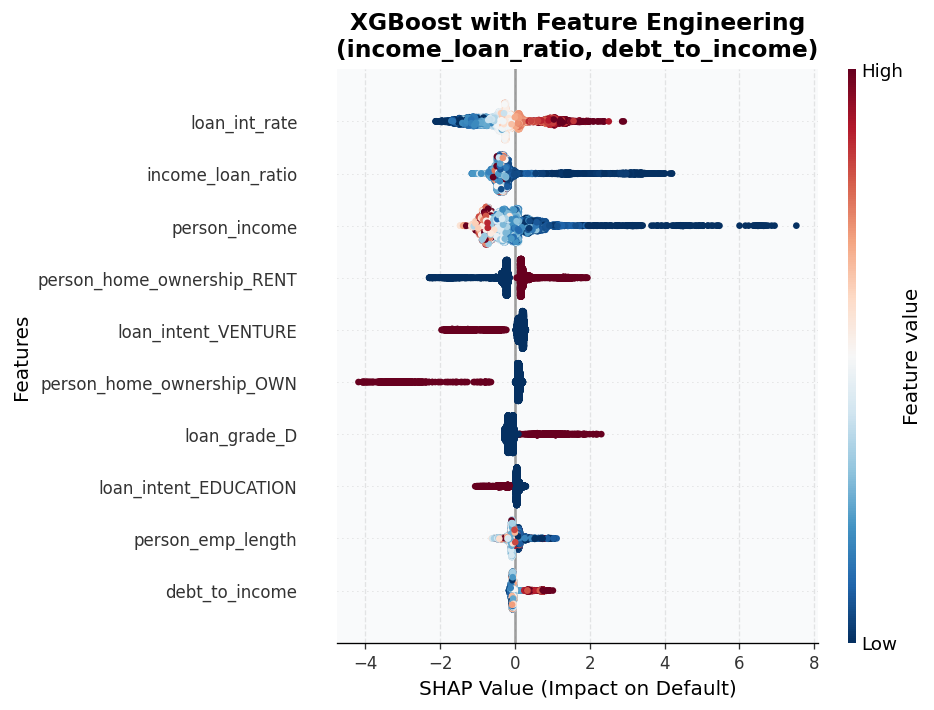

In [20]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming xgb_fe, X_test from previous chunks
# --- SHAP Analysis for XGBoost with Feature Engineering ---
plt.clf()
plt.rcParams['axes.facecolor'] = '#F9FAFB'
plt.rcParams['figure.dpi'] = 120

try:
    explainer = shap.TreeExplainer(xgb_fe)
    shap_values = explainer.shap_values(X_test)
    plt.figure(figsize=(8, 6))
    shap.summary_plot(
        shap_values,
        X_test,
        plot_type='dot',  # Beeswarm plot
        max_display=10,  # Top 10 features
        show=False,
        cmap=plt.cm.get_cmap('RdBu_r'),  # Red: positive, Blue: negative
        plot_size=None
    )
    plt.title('XGBoost with Feature Engineering\n(income_loan_ratio, debt_to_income)', fontsize=14, pad=8, weight='bold')
    plt.xlabel('SHAP Value (Impact on Default)', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.gca().tick_params(axis='both', which='major', labelsize=10)
    plt.gca().set_facecolor('#F9FAFB')
    plt.grid(True, axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout(pad=1.0)
    plt.show()
except Exception as e:
    print(f"Error in SHAP for XGBoost with Feature Engineering: {e}")

9: XGBoost with Cost-Sensitive Learning


XGBoost with Cost-Sensitive Learning Performance:
Accuracy: 0.9288
Precision: 0.9536
Recall: 0.7080
F1: 0.8126
F1 Macro: 0.8843
CV F1 Macro: 0.8898

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      5095
           1       0.95      0.71      0.81      1421

    accuracy                           0.93      6516
   macro avg       0.94      0.85      0.88      6516
weighted avg       0.93      0.93      0.92      6516



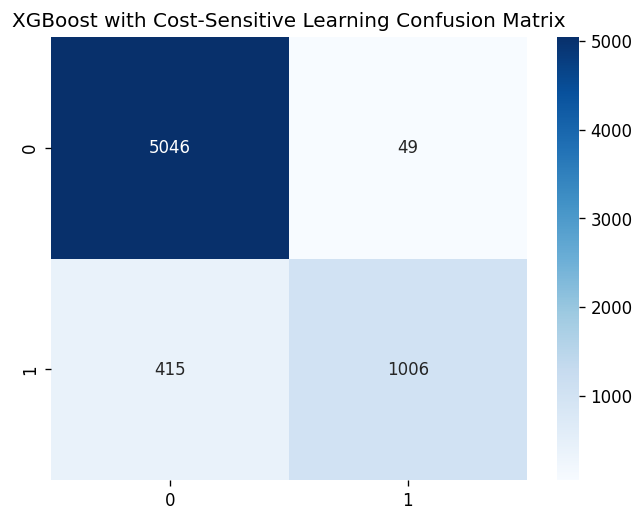

In [21]:
import xgboost as xgb
import numpy as np

# Assuming X_train, X_test, y_train, y_test, evaluate_model from previous chunks
# --- XGBoost with Cost-Sensitive Learning ---
sample_weights = np.where(y_train == 1, 5, 1)  # 5x penalty for minority class

xgb_cost = xgb.XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    learning_rate=0.1,
    n_estimators=100,
    max_depth=5,
    reg_alpha=0.1,
    reg_lambda=1.0
)
xgb_cost.fit(X_train, y_train, sample_weight=sample_weights)
cost_metrics = evaluate_model(xgb_cost, X_train, X_test, y_train, y_test, "XGBoost with Cost-Sensitive Learning")

<Figure size 768x576 with 0 Axes>

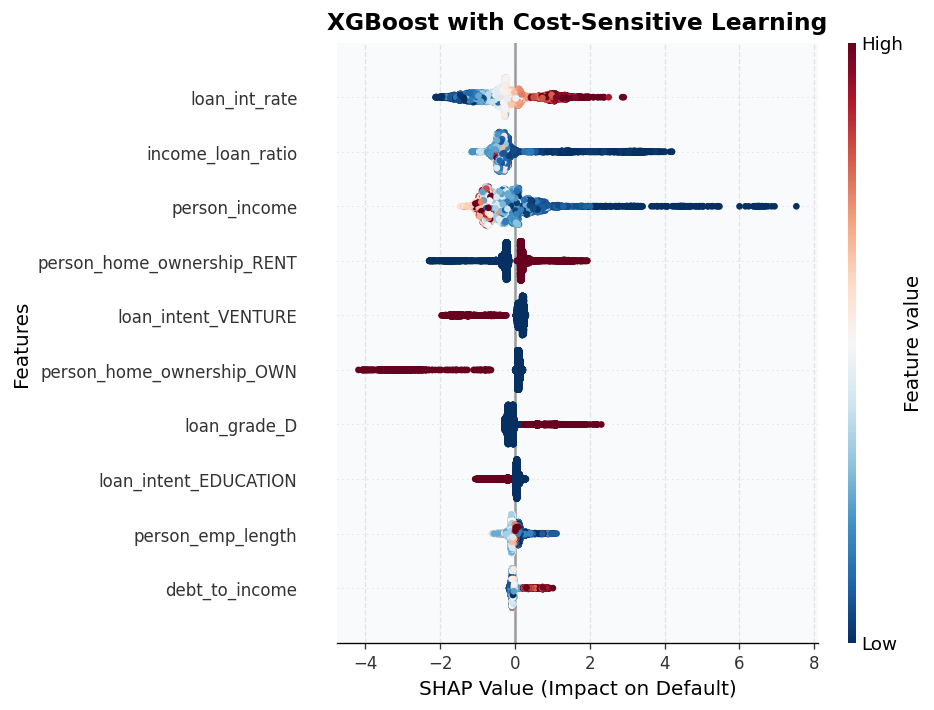

In [22]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming xgb_cost, X_test from previous chunks
# --- SHAP Analysis for XGBoost with Cost-Sensitive Learning ---
plt.clf()
plt.rcParams['axes.facecolor'] = '#F9FAFB'
plt.rcParams['figure.dpi'] = 120

try:
    explainer = shap.TreeExplainer(xgb_cost)
    shap_values = explainer.shap_values(X_test)
    plt.figure(figsize=(8, 6))
    shap.summary_plot(
        shap_values,
        X_test,
        plot_type='dot',  # Beeswarm plot
        max_display=10,  # Top 10 features
        show=False,
        cmap=plt.cm.get_cmap('RdBu_r'),  # Red: positive, Blue: negative
        plot_size=None
    )
    plt.title('XGBoost with Cost-Sensitive Learning', fontsize=14, pad=8, weight='bold')
    plt.xlabel('SHAP Value (Impact on Default)', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.gca().tick_params(axis='both', which='major', labelsize=10)
    plt.gca().set_facecolor('#F9FAFB')
    plt.grid(True, axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout(pad=1.0)
    plt.show()
except Exception as e:
    print(f"Error in SHAP for XGBoost with Cost-Sensitive Learning: {e}")

11: Comparative Analysis

In [23]:
import pandas as pd

# --- Comparative Analysis ---
metrics_df = pd.DataFrame({
    'Model': ['Vanilla XGBoost', 'XGBoost with Weighted Classes', 'XGBoost with Feature Engineering', 'XGBoost with Cost-Sensitive'],
    'Accuracy': [vanilla_metrics['Accuracy'], weighted_metrics['Accuracy'], fe_metrics['Accuracy'], cost_metrics['Accuracy']]
})

print("\nComparative Analysis of Models (Accuracy):")
print(metrics_df.round(4).to_string(index=False))


Comparative Analysis of Models (Accuracy):
                           Model  Accuracy
                 Vanilla XGBoost    0.9282
   XGBoost with Weighted Classes    0.8938
XGBoost with Feature Engineering    0.9288
     XGBoost with Cost-Sensitive    0.9288


In [24]:
import pandas as pd

# Assuming vanilla_metrics, weighted_metrics, fe_metrics, cost_metrics from previous chunks
# --- Comparative Analysis with F1 Macro ---
metrics_df = pd.DataFrame({
    'Model': ['Vanilla XGBoost', 'XGBoost with Weighted Classes', 'XGBoost with Feature Engineering', 'XGBoost with Cost-Sensitive'],
    'F1 Macro': [vanilla_metrics['F1 Macro'], weighted_metrics['F1 Macro'], fe_metrics['F1 Macro'], cost_metrics['F1 Macro']]
})

print("\nComparative Analysis of Models (F1 Macro):")
print(metrics_df.round(4).to_string(index=False))


Comparative Analysis of Models (F1 Macro):
                           Model  F1 Macro
                 Vanilla XGBoost    0.8838
   XGBoost with Weighted Classes    0.8465
XGBoost with Feature Engineering    0.8843
     XGBoost with Cost-Sensitive    0.8843


In [25]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Assuming X_train, y_train from Chunk 4 (train-test split)
# --- Apply SMOTE to Training Data ---
print("Class distribution before SMOTE:")
print(y_train.value_counts(normalize=True))

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Convert back to DataFrame to preserve column names for SHAP
X_train_smote = pd.DataFrame(X_train_smote, columns=X_train.columns)

print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts(normalize=True))

Class distribution before SMOTE:
loan_status
0    0.781836
1    0.218164
Name: proportion, dtype: float64

Class distribution after SMOTE:
loan_status
0    0.5
1    0.5
Name: proportion, dtype: float64



XGBoost with Weighted Classes with SMOTE Performance:
Accuracy: 0.9216
Precision: 0.9027
Recall: 0.7178
F1: 0.7997
F1 Macro: 0.8755
CV F1 Macro: 0.9291

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      5095
           1       0.90      0.72      0.80      1421

    accuracy                           0.92      6516
   macro avg       0.91      0.85      0.88      6516
weighted avg       0.92      0.92      0.92      6516



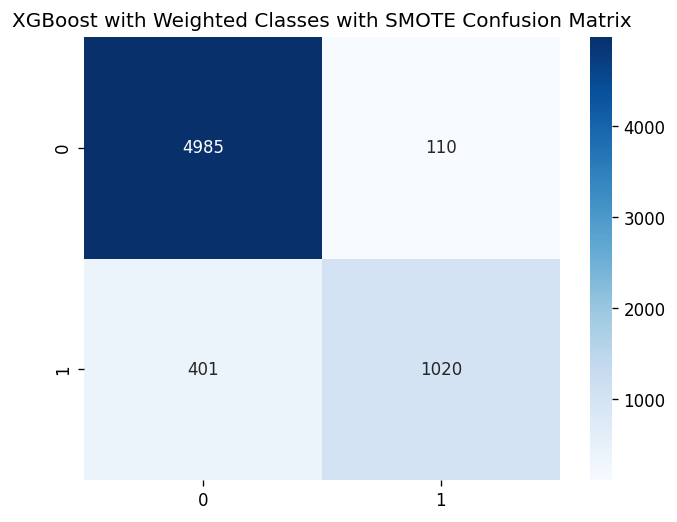

In [26]:
import xgboost as xgb

# Assuming X_train_smote, y_train_smote, X_test, y_test, evaluate_model from previous chunks
# --- XGBoost with Weighted Classes with SMOTE ---
scale_pos_weight = (y_train_smote == 0).sum() / (y_train_smote == 1).sum()  # Adjust for SMOTE-balanced data

xgb_weighted = xgb.XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    learning_rate=0.1,
    n_estimators=100,
    max_depth=5,
    reg_alpha=0.1,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight
)
weighted_metrics = evaluate_model(xgb_weighted, X_train_smote, X_test, y_train_smote, y_test, "XGBoost with Weighted Classes with SMOTE")

In [ ]:
import xgboost as xgb

# Assuming X_train_smote, y_train_smote, X_test_vanilla, y_test, evaluate_model from previous chunks
# --- Vanilla XGBoost with SMOTE ---
original_cols = [col for col in X_train_smote.columns if col not in ['income_loan_ratio', 'debt_to_income']]
X_train_vanilla_smote = X_train_smote[original_cols]
X_test_vanilla = X_test[original_cols]

xgb_vanilla = xgb.XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    learning_rate=0.1,
    n_estimators=100,
    max_depth=5,
    reg_alpha=0.1,
    reg_lambda=1.0
)
vanilla_metrics = evaluate_model(xgb_vanilla, X_train_vanilla_smote, X_test_vanilla, y_train_smote, y_test, "Vanilla XGBoost with SMOTE")